
[Reference](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)

## Fitting a sine wave with third order polynomial - Version 1

In [1]:
import wandb

WANDB_API_KEY = 'local-acb620b3ffcec7d4f7c759814696231e09738bc3'
wandb.login(key=WANDB_API_KEY, host="https://wandb.data.zalan.do")

wandb: Currently logged in as: pnakhe. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for wandb.data.zalan.do to your netrc file: /Users/pnakhe/.netrc


True

In [2]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import torch
import math
from datetime import date, timedelta, datetime

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# Create random input and output data
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Randomly initialize weights
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

    # Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 268.88848876953125
199 183.880126953125
299 126.76875305175781
399 88.36322784423828
499 62.51424026489258
599 45.100738525390625
699 33.359134674072266
799 25.434368133544922
899 20.080432891845703
999 16.459674835205078
1099 14.008585929870605
1199 12.347492218017578
1299 11.220602989196777
1399 10.455276489257812
1499 9.934931755065918
1599 9.580737113952637
1699 9.339385986328125
1799 9.174736976623535
1899 9.062277793884277
1999 8.985379219055176
Result: y = -0.010235917754471302 + 0.8483393788337708 x + 0.0017658653669059277 x^2 + -0.09213535487651825 x^3


## Fitting a sine wave with third order polynomial - Autograd

Using [Autograd](https://www.youtube.com/watch?v=MswxJw-8PvE)

For a more detailed view on autograd, see this [tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

In [15]:
a = torch.randn((), dtype=dtype, requires_grad=True)
b = torch.randn((), dtype=dtype, requires_grad=True)
c = torch.randn((), dtype=dtype, requires_grad=True)
d = torch.randn((), dtype=dtype, requires_grad=True)

learning_rate = 1e-6

wandb.init(
    project="torch-demo",
    job_type="model_training",
    name=f"autograd_{datetime.now().strftime("%Y%m%d%H%M")}",
    config=dict(learning_date=learning_rate)
)

for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Now loss is a Tensor of shape (1,)
    loss = (y_pred - y).pow(2).sum()

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    if t % 100 == 99:
        print(t, loss.item())
        wandb.log({
            "loss": loss.item(), 
            "gradient_a":a.grad.item(),
            "iteration": t})
    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')
wandb.finish()

99 601.7288818359375
199 401.23480224609375
299 268.554443359375
399 180.7462615966797
499 122.63111114501953
599 84.16546630859375
699 58.704105377197266
799 41.84944534301758
899 30.691320419311523
999 23.303791046142578
1099 18.412261962890625
1199 15.173089027404785
1299 13.027913093566895
1399 11.607126235961914
1499 10.665970802307129
1599 10.042486190795898
1699 9.62939453125
1799 9.355655670166016
1899 9.174233436584473
1999 9.053977012634277
Result: y = -0.0034639406949281693 + 0.8421239852905273 x + 0.0005975862732157111 x^2 + -0.09125126153230667 x^3


gradient_a,▁▂▃▄▅▅▆▆▆▇▇▇▇███████
iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
gradient_a,-5.99437
iteration,1999
loss,9.05398


## Defining new autograd functions

In [3]:
class LegendrePoly(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return 0.5 * (5 * input**3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return grad_output * 1.5 * (5 * input**2 - 1)

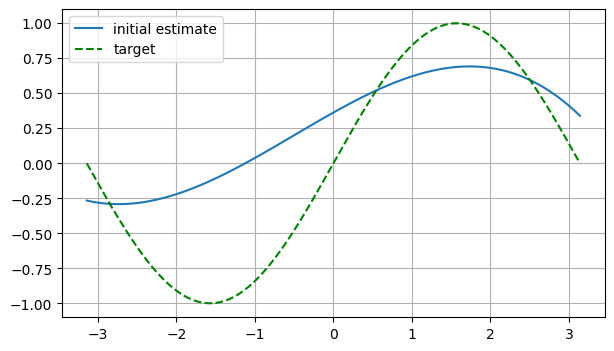

199 124.17093658447266
399 61.68357849121094
599 33.11712646484375
799 20.003429412841797
999 13.97114086151123
1199 11.193151473999023
1399 9.912884712219238
1599 9.322577476501465
1799 9.050336837768555
1999 8.924735069274902
Result: y = 1.1761941420829203e-09 + -2.210512161254883 * P3(3.332241704789851e-10 + 0.2554997205734253 x)


gradient_a,█▁▁▁▁▁▁▁▁▁
iteration,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▁▁▁▁▁▁
gradient_a,0.0
iteration,1999
loss,8.92474


In [27]:
a = torch.full((), 0.2, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.1, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.1, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.2, device=device, dtype=dtype, requires_grad=True)

# To apply our Function, we use Function.apply method. We alias this as 'P3'.
P3 = LegendrePoly.apply

fig, ax = plt.subplots(figsize=(7, 4))

y_pred = a + b * P3(c + d * x)
ax.plot(x.tolist(), y_pred.tolist(), label="initial estimate")
ax.plot(x.tolist(), y.tolist(), 'g--', label="target")
ax.grid(True)

plt.legend()
plt.show()

learning_rate = 5e-6

wandb.init(
    project="torch-demo",
    job_type="model_training",
    group="P3",
    name=f"autograd_{datetime.now().strftime('%Y%m%d%H%M')}",
    config=dict(learning_date=learning_rate)
)

for t in range(2000):
    
    # Forward pass: compute predicted y using operations; we compute
    # P3 using our custom autograd operation.
    y_pred = a + b * P3(c + d * x)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()

    # Use autograd to compute the backward pass.
    loss.backward()

    if t % 200 == 199:
        print(t, loss.item())
        # plot to see the goodness of fit every 200 rounds
        fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
        ax[0].plot(x.tolist(), y_pred.tolist())
        ax[0].grid(True)
        
        wandb.log({
            "loss": loss.item(), 
            "gradient_a":a.grad.item(),
            "iteration": t,
            "fit_plot": fig})
        
    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

wandb.finish()

## nn module

In [30]:
# help(torch.nn.HuberLoss)

In [38]:
# For this example, the output y is a linear function of (x, x^2, x^3), so
# we can consider it as a linear layer neural network. Let's prepare the
# tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. The Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# The Flatten layer flatens the output of the linear layer to a 1D tensor,
# to match the shape of `y`.
# See https://pytorch.org/docs/stable/notes/modules.html for custom modules.
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)

loss_fn = torch.nn.HuberLoss(reduction='mean')

wandb.init(
    project="torch-demo",
    job_type="model_training",
    group="nn_module",
    name=f"autograd_{datetime.now().strftime('%Y%m%d%H%M')}",
    config=dict(learning_date=learning_rate)
)


learning_rate = 1e-6
for t in range(2000):

    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(xx)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()
    if t % 100 == 99:
        print(t, loss.item())
        wandb.log({"loss": loss})

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

# You can access the first layer of `model` like accessing the first item of a list (Really cool!)
linear_layer = model[0]

# For linear layer, its parameters are stored as `weight` and `bias`.
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

wandb.finish()

loss,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
loss,0.74472


99 2.3461103439331055
199 2.3409159183502197
299 2.335723400115967
399 2.3305327892303467
499 2.325343370437622
599 2.320155382156372
699 2.314969062805176
799 2.309784173965454
899 2.3046014308929443
999 2.29941987991333
1099 2.2942399978637695
1199 2.2890615463256836
1299 2.2838847637176514
1399 2.27871036529541
1499 2.2735369205474854
1599 2.2683827877044678
1699 2.2632339000701904
1799 2.258086681365967
1899 2.252941131591797
1999 2.2477972507476807
Result: y = 0.5625269412994385 + -0.040942855179309845 x + -0.3189057409763336 x^2 + 0.38256391882896423 x^3


loss,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
loss,2.2478


In [41]:
[*linear_layer.parameters()]

[Parameter containing:
 tensor([[-0.0409, -0.3189,  0.3826]], requires_grad=True),
 Parameter containing:
 tensor([0.5625], requires_grad=True)]

### Custom NN Modules

In [ ]:
# -*- coding: utf-8 -*-
import torch
import math


class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        # note the parameters are instances of torch.nn.Parameter
        # I am guess this is to ensure that the Optimizer knows how
        # to update them.
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# Construct our model by instantiating the class defined above
model = Polynomial3()

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Result: {model.string()}')